# NOTE: Answers to question 1 (a-c) are all at the bottom of this notebook

In [1]:
import pandas as pd  
import numpy as np 
import seaborn as sns

### Read in the data and check it's format for useability
- check the variable types 
- check for any missing data

In [2]:
shoe_orders_df = pd.read_csv('q1_data_set.csv')
shoe_orders_df.head()

order_id  shop_id  user_id  order_amount  total_items payment_method  \
0         1       53      746           224            2           cash   
1         2       92      925            90            1           cash   
2         3       44      861           144            1           cash   
3         4       18      935           156            1    credit_card   
4         5       18      883           156            1    credit_card   

            created_at  
0  2017-03-13 12:36:56  
1  2017-03-03 17:38:52  
2   2017-03-14 4:23:56  
3  2017-03-26 12:43:37  
4   2017-03-01 4:35:11

In [3]:
shoe_orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   order_id        5000 non-null   int64 
 1   shop_id         5000 non-null   int64 
 2   user_id         5000 non-null   int64 
 3   order_amount    5000 non-null   int64 
 4   total_items     5000 non-null   int64 
 5   payment_method  5000 non-null   object
 6   created_at      5000 non-null   object
dtypes: int64(5), object(2)
memory usage: 273.6+ KB


In [4]:
print('created_at dtype:', type(shoe_orders_df['created_at'][0]))
print('Different payment methods:', shoe_orders_df['payment_method'].unique())

created_at dtype: <class 'str'>
Different payment methods: ['cash' 'credit_card' 'debit']


### Clean the data
- Before looking into anything, the data should be cleaned to avoid having to do this later on 
- Extract information from the created_at to have individual numerical features (easy to use later on)

In [5]:
from typing import List
def extract_time(df: pd.DataFrame, col_name: str = 'created_at', drop: bool = True) -> pd.DataFrame:
    """ Extract date/time data from the created_at column

    Args: 
        df: The current dataframe in use
        col_name: The column to extract time data from
        drop: If true, drop the original time column 

    Returns: 
        A new dataframe containing new column with separate information about date and time
    """
    df = df.copy()

    datetime_col = pd.to_datetime(df[col_name])
    # extract date info 
    df['day'] = datetime_col.dt.day
    df['month'] = datetime_col.dt.month
    df['year'] = datetime_col.dt.year
    df['weekday'] = datetime_col.dt.dayofweek
    df['year_day'] = datetime_col.dt.dayofyear

    # extract time info; ignore the seconds (different in seconds sholud not matter for orders)
    df['hours_time'] = datetime_col.dt.hour + (datetime_col.dt.minute / 60)

    if drop:
        df.drop(columns=[col_name], inplace=True)

    return df
orders_df = extract_time(shoe_orders_df)
orders_df.head()

order_id  shop_id  user_id  order_amount  total_items payment_method  day  \
0         1       53      746           224            2           cash   13   
1         2       92      925            90            1           cash    3   
2         3       44      861           144            1           cash   14   
3         4       18      935           156            1    credit_card   26   
4         5       18      883           156            1    credit_card    1   

   month  year  weekday  year_day  hours_time  
0      3  2017        0        72   12.600000  
1      3  2017        4        62   17.633333  
2      3  2017        1        73    4.383333  
3      3  2017        6        85   12.716667  
4      3  2017        2        60    4.583333

In [6]:
orders_df.shape

(5000, 12)

### EDA
- Perform some exploratory data analysis by drawing some graphs of the data
- Visualize the data to see anything that might point outliers

Text(0.5, 1.0, 'Order vs Price')

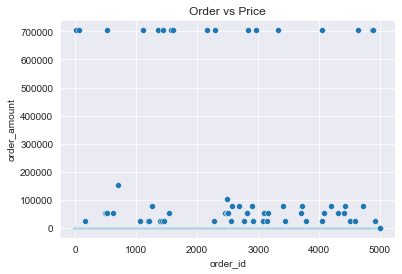

In [7]:
import seaborn as sns
sns.set_style('darkgrid')
# graph each order against order_amount to see how order order amount is distirbuted
price_by_order = sns.scatterplot(x='order_id', y='order_amount', data=orders_df)
price_by_order.set_title('Order vs Price')

- since there are many unique orders, examine the order total by shop id, user id and total items 
- When aggregating the data with mean aggregations in each of these 3 columns, factors affecting the AOV will start to become apparent

In [8]:
avg_cost_by_shop = orders_df.groupby('shop_id')['order_amount'].mean().sort_values(ascending=False)
avg_cost_by_user = orders_df.groupby('user_id')['order_amount'].mean().sort_values(ascending=False)
avg_cost_by_quantity = orders_df.groupby('total_items')['order_amount'].mean().sort_values(ascending=False)

In [9]:
avg_cost_by_shop.head()

shop_id
42    235101.490196
78     49213.043478
50       403.545455
90       403.224490
38       390.857143
Name: order_amount, dtype: float64

In [10]:
avg_cost_by_user.head()

user_id
607    704000.000000
878     14266.909091
766      8007.600000
834      6019.000000
915      5785.142857
Name: order_amount, dtype: float64

In [11]:
avg_cost_by_quantity.head()

total_items
2000    704000.000000
6        17940.000000
3         1191.076514
8         1064.000000
4          947.686007
Name: order_amount, dtype: float64

Text(0.5, 1.0, 'Order vs Price by user')

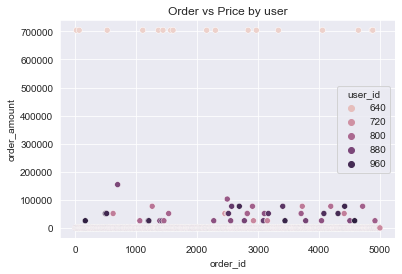

In [12]:
# same graph as the first one except with user_id as the hue
price_by_order = sns.scatterplot(x='order_id', y='order_amount', data=orders_df, hue='user_id')
price_by_order.set_title('Order vs Price by user')

### Explore the effects of quantity and store cost
- Since each store sells one shoe, look at costs by shop
- See how order quantity affects cost

Text(0.5, 1.0, 'Price per Shoe vs Order Amount')

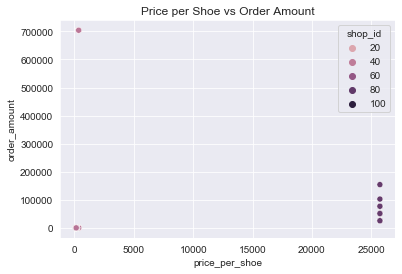

In [13]:
orders_df['price_per_shoe'] = orders_df['order_amount'] / orders_df['total_items']

per_shoe_ax = sns.scatterplot(x='price_per_shoe', y='order_amount', hue='shop_id', data=orders_df)
per_shoe_ax.set_title('Price per Shoe vs Order Amount')

- evidently, one shop sells very expensive shoes

Text(0.5, 1.0, 'Total Items Ordered vs Order Amount: Range All')

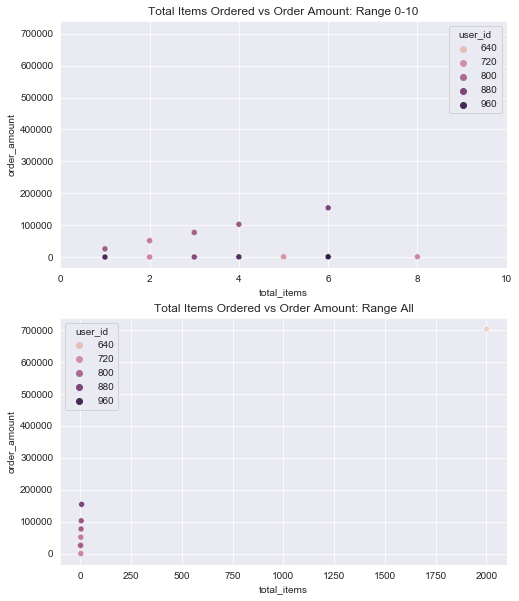

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, figsize=(8, 10))

quantity_v_amount_ax = sns.scatterplot(x='total_items', y='order_amount', hue='user_id', data=orders_df, ax=ax[0])
quantity_v_amount_ax.set_title('Total Items Ordered vs Order Amount: Range 0-10')
quantity_v_amount_ax.set_xlim(0, 10)

quantity_v_amount_ax_2 = sns.scatterplot(x='total_items', y='order_amount', hue='user_id', data=orders_df, ax=ax[1])
quantity_v_amount_ax_2.set_title('Total Items Ordered vs Order Amount: Range All')

- Other than the one order which has 2000 items per order, all other orders fall in the 1-8 item range per order

### Examine any time data 
- Since all the orders are made over a 30 day period, see if there is anything strange with amount of orders on certain days

Text(0.5, 0, 'Day of Year')

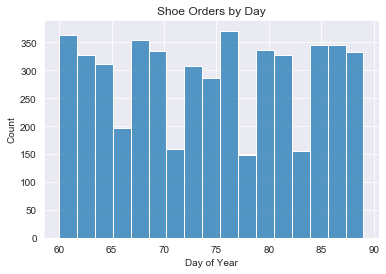

In [15]:
# we only have data made from 2017, see the amount of orders by month
orders_by_day = sns.histplot(x='year_day', data=orders_df)
orders_by_day.set_title('Shoe Orders by Day')
orders_by_day.set_xlabel('Day of Year')

Text(0.5, 1.0, 'Shoe orders by hour')

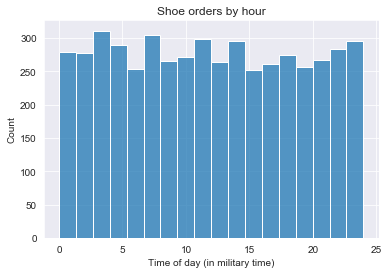

In [16]:
orders_by_hour = sns.histplot(x='hours_time', data=orders_df)
orders_by_hour.set_xlabel('Time of day (in military time)')
orders_by_hour.set_title('Shoe orders by hour')

### Examine payment methods
- See if any of the payment methods had differences

Text(0.5, 1.0, 'Orders by Payment')

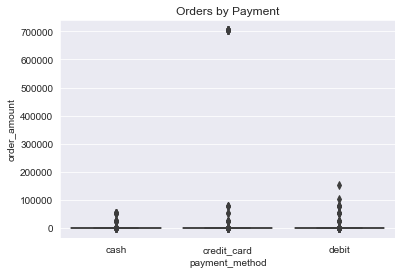

In [17]:
orders_by_payment = sns.boxplot(x='payment_method', y='order_amount', data=orders_df)
orders_by_payment.set_title('Orders by Payment')

### Look at the standard deviation of the order amount to see how spread the data is
- To quanitfy order amount spread with outliers, calculate standard deviation

In [27]:
order_cost_std = orders_df['order_amount'].std()
order_cost_mean = orders_df['order_amount'].mean()
order_quantity_std = orders_df['total_items'].std()
order_quantity_mean = orders_df['total_items'].mean()
print('Order cost standard dev: $' + str(order_cost_std))
print('Order cost mean: $' + str(order_cost_mean))
print('Order quantity standard dev: ' + str(order_quantity_std) + ' items')
print('Order quantity mean: ' + str(order_quantity_mean) + ' items')

Order cost standard dev: $41282.539348788196
Order cost mean: $3145.128
Order quantity standard dev: 116.32031980492717 items
Order quantity mean: 8.7872 items


- Both the means for average order value (order cost mean) and order quantity mean are very high
- The standard deviation for both values is also very high. From the previous data exploration, outliers are the cause of this

### To get the outliers, I can train an isolation forest on the order amount
- Certain shops and users have higher average order values (above)
- From the scatter plot it seems like there are around 1% of samples that are outliers, train an isolation forest to identify these outliers

In [19]:
from sklearn.ensemble import IsolationForest

def make_isolation_forest(df: pd.DataFrame, n_estimators: int, contamination: float) -> pd.DataFrame:
    # create an isolation forest model
    detector = IsolationForest(n_estimators=n_estimators, contamination=contamination, random_state=8)
    detector.fit(df[['order_amount']])
    # fit the isolation forest and add it to the df to see the outliers
    outlier_df = df.copy()
    outlier_df['outlier'] = detector.predict(outlier_df[['order_amount']])
    outlier_df['score'] = detector.decision_function(outlier_df[['order_amount']])

    return outlier_df

# add the new columns from the isolation forest to a df
outlier_df = make_isolation_forest(orders_df, 50, 0.01)

Text(0.5, 1.0, 'Outliers using Iso Forest')

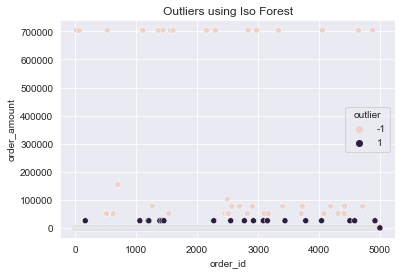

In [20]:
outlier_ax = sns.scatterplot(x='order_id', y='order_amount', hue='outlier', data=outlier_df)
outlier_ax.set_title('Outliers using Iso Forest')

In [21]:
only_outlier_df = outlier_df.loc[outlier_df['outlier'] == -1]
only_outlier_df.sort_values(by='order_amount', ascending=False).head(30)

order_id  shop_id  user_id  order_amount  total_items payment_method  \
15          16       42      607        704000         2000    credit_card   
1562      1563       42      607        704000         2000    credit_card   
4868      4869       42      607        704000         2000    credit_card   
4646      4647       42      607        704000         2000    credit_card   
4056      4057       42      607        704000         2000    credit_card   
3332      3333       42      607        704000         2000    credit_card   
2969      2970       42      607        704000         2000    credit_card   
2835      2836       42      607        704000         2000    credit_card   
60          61       42      607        704000         2000    credit_card   
2297      2298       42      607        704000         2000    credit_card   
2153      2154       42      607        704000         2000    credit_card   
1602      1603       42      607        704000         2000    credit_card   
4882      4883       42      607        704000         2000    credit_card   
1362      1363       42      607        704000         2000    credit_card   
520        521       42      607        704000         2000    credit_card   
1436      1437       42      607        704000         2000    credit_card   
1104      1105       42      607        704000         2000    credit_card   
691        692       78      878        154350            6          debit   
2492      2493       78      834        102900            4          debit   
2690      2691       78      962         77175            3          debit   
3403      3404       78      928         77175            3          debit   
4192      4193       78      787         77175            3    credit_card   
2906      2907       78      817         77175            3          debit   
4420      4421       78      969         77175            3          debit   
2564      2565       78      915         77175            3          debit   
4715      4716       78      818         77175            3          debit   
1259      1260       78      775         77175            3    credit_card   
3724      3725       78      766         77175            3    credit_card   
4412      4413       78      756         51450            2          debit   
511        512       78      967         51450            2           cash   

      day  month  year  weekday  year_day  hours_time  price_per_shoe  \
15      7      3  2017        1        66    4.000000           352.0   
1562   19      3  2017        6        78    4.000000           352.0   
4868   22      3  2017        2        81    4.000000           352.0   
4646    2      3  2017        3        61    4.000000           352.0   
4056   28      3  2017        1        87    4.000000           352.0   
3332   24      3  2017        4        83    4.000000           352.0   
2969   28      3  2017        1        87    4.000000           352.0   
2835   28      3  2017        1        87    4.000000           352.0   
60      4      3  2017        5        63    4.000000           352.0   
2297    7      3  2017        1        66    4.000000           352.0   
2153   12      3  2017        6        71    4.000000           352.0   
1602   17      3  2017        4        76    4.000000           352.0   
4882   25      3  2017        5        84    4.000000           352.0   
1362   15      3  2017        2        74    4.000000           352.0   
520     2      3  2017        3        61    4.000000           352.0   
1436   11      3  2017        5        70    4.000000           352.0   
1104   24      3  2017        4        83    4.000000           352.0   
691    27      3  2017        0        86   22.850000         25725.0   
2492    4      3  2017        5        63    4.616667         25725.0   
2690   22      3  2017        2        81    7.550000         25725.0   
3403   16      3  2017        3        75    9.750000 

In [22]:
only_outlier_df.sort_values(by='price_per_shoe', ascending=False).head(50)

order_id  shop_id  user_id  order_amount  total_items payment_method  \
2690      2691       78      962         77175            3          debit   
3403      3404       78      928         77175            3          debit   
3101      3102       78      855         51450            2    credit_card   
3705      3706       78      828         51450            2    credit_card   
2906      2907       78      817         77175            3          debit   
3724      3725       78      766         77175            3    credit_card   
2821      2822       78      814         51450            2           cash   
2818      2819       78      869         51450            2          debit   
2564      2565       78      915         77175            3          debit   
2512      2513       78      935         51450            2          debit   
2495      2496       78      707         51450            2           cash   
2492      2493       78      834        102900            4          debit   
2452      2453       78      709         51450            2           cash   
4079      4080       78      946         51450            2           cash   
4192      4193       78      787         77175            3    credit_card   
4311      4312       78      960         51450            2          debit   
4412      4413       78      756         51450            2          debit   
1529      1530       78      810         51450            2           cash   
4420      4421       78      969         77175            3          debit   
1259      1260       78      775         77175            3    credit_card   
4715      4716       78      818         77175            3          debit   
691        692       78      878        154350            6          debit   
617        618       78      760         51450            2           cash   
511        512       78      967         51450            2           cash   
493        494       78      983         51450            2           cash   
490        491       78      936         51450            2          debit   
3167      3168       78      927         51450            2           cash   
4646      4647       42      607        704000         2000    credit_card   
4056      4057       42      607        704000         2000    credit_card   
4868      4869       42      607        704000         2000    credit_card   
15          16       42      607        704000         2000    credit_card   
3332      3333       42      607        704000         2000    credit_card   
2969      2970       42      607        704000         2000    credit_card   
2835      2836       42      607        704000         2000    credit_card   
60          61       42      607        704000         2000    credit_card   
2297      2298       42      607        704000         2000    credit_card   
2153      2154       42      607        704000         2000    credit_card   
1602      1603       42      607        704000         2000    credit_card   
1562      1563       42      607        704000         2000    credit_card   
1436      1437       42      607        704000         2000    credit_card   
1362      1363       42      607        704000         2000    credit_card   
1104      1105       42      607        704000         2000    credit_card   
520        521       42      607        704000         2000    credit_card   
4882      4883       42      607        704000         2000    credit_card   

      day  month  year  weekday  year_day  hours_time  price_per_shoe  \
2690   22      3  2017        2        81    7.550000         25725.0   
3403   16      3  2017        3        75    9.750000         25725.0   
3101   21      3  2017        1        80    5.166667         25725.0   
3705   14      3  2017        1        73   20.716667         25725.0   
2906   16      3  2017        3        75    3.750000         25725.0   
3724   16      3  2017        3        75   14.216667    

In [23]:
only_outlier_df['shop_id'].unique()

array([42, 78], dtype=int64)

### Calculate order amount standard deviation without the outliers
- See if the standard deviation has been reduced by removing 1% of the outlier data

In [24]:
iso_forest_std_1 = outlier_df.loc[outlier_df['outlier']==1, 'order_amount'].std()
print('Standard deviation of order costs with 1% of outliers removed: $' + str(iso_forest_std_1))

Standard deviation of order costs with 1% of outliers removed: $1579.39864615807


### Experiment with a slightly higher contamination % and see if the new standard deviation for non-outliers changes greater
- By setting 1% contamination in the iso forest, the standard deviation for order prices is still high 
- This may potentially be because I took a contamination value that was too low - raise the contamination value to 2% and re-evaluate

In [25]:
outlier_df_2 = make_isolation_forest(orders_df, 50, 0.02)
no_outliers_std = outlier_df_2.loc[outlier_df_2['outlier']==1, 'order_amount'].std()
no_outliers_mean = outlier_df_2.loc[outlier_df_2['outlier']==1, 'order_amount'].mean()
total_items_std = outlier_df_2.loc[outlier_df_2['outlier']==1, 'total_items'].std()
total_items_mean = outlier_df_2.loc[outlier_df_2['outlier']==1, 'total_items'].mean()
print('Standard Dev. order cost With 2% outliers removed: $' + str(no_outliers_std))
print('Mean order cost With 2% outliers removed: $' + str(no_outliers_mean))
print('Standard Dev. order quantity With 2% outliers removed: ' + str(total_items_std) + ' items')
print('Mean order quantity With 2% outliers removed: ' + str(total_items_mean) + ' items')

Standard Dev. order cost With 2% outliers removed: $150.1545343387477
Mean order cost With 2% outliers removed: $297.66714285714284
Standard Dev. order quantity With 2% outliers removed: 0.9491329518711279 items
Mean order quantity With 2% outliers removed: 1.9724489795918367 items


### Findings
- Before removing outliers, std order cost was greater than $40,000
- After removing 1% of outliers, std order cost was around $1500 (still high)
- When indicating 2% of values as outliers, the standard deviation greatly drops off to $150, a value that looks much more reasonable for shoe order values and seems to have more consistent order costs (due to lower standard deviation)
- After removing the outliers, the total items and order costs have relatively low standard deviation which can be useful to generalize findings from this data set

# 1A: What is going wrong with AOV
- After visualizing the inital data, it is clear that there are outliers in the data casuing the mean/average and standard deviation to shoot up
- With the results from the isolation forest, three specific insights are revelaed
1. The user with user_id 607 ordered 2000 shoes various times in the month. This resulted in extremely high order costs which greatly skewed the average
2. A certain shop (specifically shop_id 78 in this case) sold very expensive shoes - valued at $25,725 per shoe. This implies than even small order quantities from this shop would still drive the average order value up
3. By removing 2% of 'outliers', it is revealed that the standard deviation for order amount goes from $40,000 -> $150 and order quantity goes from 114 items -> 0.94 items. There is much less variance in both of these fields without the outliers which can be very useful to generalize results for this data set

- Due to finding outliers in both user buying habits and shoe costs, **means/averages should not be used to evalute any metric on the data**
- To better evalute this data, methods that look for central values and ignore outliers (like medians) would be much more appropriate

# 1B: What Metric?
- Since the initial task was to calculate average order value, Shopify likely wants to understand more about average user spending habits
- To understand these habits better, looking at the price per shoe of an order would remove the variability in the quantity of the order and focus on the price point that the average user is paying (removing outliers due to order quantity)
- Median price per shoe (aka median order value per shoe) will give direct insight into customer spending habits - by using a median I am in effect removing the small amount outliers in shoe cost and getting a value that is much more representative of the majority of user spending habits

### Metric: Median Order Value Per Shoe

# 1C: Value of M(OV/S)?
- Use pandas to calculate the median (order value per shoe)

In [26]:
final_metric = (orders_df['order_amount'] / orders_df['total_items']).median()
final_metric

153.0

### Median Order Value per shoe = $153/shoe
- This tells me that the 'average' customer buying from Shopify shoe stores is looking to pay $153/shoe